# Deep Learning for NLP - Exercise 01
Building, Tuning and Evaluating a standard RNN Model

General hints:
* Have a look at the imports below when solving the tasks
* Use the given modules and all submodules of the imports, but don't import anything else!
    * For instance, you can use other functions under the `torch` or `nn` namespace, but don't import e.g. PyTorch Lightning, etc.
* It is recommended to install all packages from the provided environment file
* Feel free to test your code between sub-tasks of the exercise sheet, so that you can spot mistakes early (wrong shapes, impossible numbers, NaNs, ...)
* Just keep in mind that your final submission should be compliant to the provided initial format of this file

Submission guidelines:
* Make sure that the code runs on package versions from the the provided environment file
* Do not add or change any imports (also don't change the naming of imports, e.g. `torch.nn.functional as f`)
* Remove your personal, additional code testings and experiments throughout the notebook
* Do not change the class, function or naming structure as we will run tests on the given names
* Additionally export this notebook as a `.py` file, and submit **both** the executed `.ipynb` notebook with plots in it **and** the `.py` file
* **Deviation from the above guidelines will result in partial or full loss of points**

If you are using Google Colab or similar services, make sure to install all necessary packages so that the import cell below is working.

Usually, you would need to `!pip install`:
```
!pip install datasets==3.0.1
!pip install spacy==3.6.1
!pip install torch==2.0.1    # just to be sure we are all working with the same version
!pip install torchtext==0.15.2
!python -m spacy download en_core_web_sm
```

Make sure to comment out the lines before submitting!

In [174]:
import os
import sys
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Sampler, BatchSampler, Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.utils import get_tokenizer

from datasets import load_dataset

In [175]:
torch.cuda.is_available()

True

In [176]:
def regularized_f1(train_f1, dev_f1, threshold=0.0015):
    """
    Returns development F1 if overfitting is below threshold, otherwise 0.
    """
    return dev_f1 if (train_f1 - dev_f1) < threshold else 0


def save_metrics(*args, path, fname):
    if not os.path.exists(path):
        os.makedirs(path)
    if not os.path.isfile(path + fname):
        with open(path + fname, "w", newline="\n") as f:
            f.write(
                ",".join(
                    [
                        "config",
                        "epoch",
                        "train_loss",
                        "train_acc",
                        "train_f1",
                        "val_loss",
                        "val_acc",
                        "val_f1",
                    ]
                )
            )
            f.write("\n")
    if args:
        with open(path + fname, "a", newline="\n") as f:
            f.write(",".join([str(arg) for arg in args]))
            f.write("\n")

def seed_everything(seed: int):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True


seed_everything(1234)

In [177]:
VOCAB_SIZE = 20_000
BATCH_SIZE = 32
NUM_EPOCHS = 15
MAX_LEN = 256
LEARNING_RATE = 1e-4

## Task 1 - Download and prepare the dataset
- Load the train and test set of IMDB (it is included in the `datasets` module we imported above)
- Split the train set into train and validation set
    * Train set should consist of the middle 10% to 85% of data
    * Validation set should be the two remaining ends
    * You can achieve this slicing directly within the `load_dataset` function, check out the [Huggingface slicing API](https://huggingface.co/docs/datasets/v2.13.1/loading#slice-splits)
- Test set should stay unchanged

In [178]:
# load dataset in splits
train_data = load_dataset("imdb", split="train[10%:85%]")
dev_data = load_dataset("imdb", split="train[:10%]+train[85%:]")
test_data = load_dataset("imdb", split="test")

* Define the tokenizer using `get_tokenizer` with spacy's `en_core_web_sm` module
    * You don't have to import spacy for that, but it is necessary to have spacy installed and the `en_core_web_sm` module downloaded
* Create the vocabulary using `build_vocab_from_iterator`
    * Think about which split(s) should be used to build the vocabulary
    * Include two special tokens: `'<UNK>'` at index `0`, `'<PAD>'` at index `1`
    * Limit the vocab size to `VOCAB_SIZE`, as defined in the beginning
    * Set the vocab's default returning index to `0` by making the `'<UNK>'` token default
    
Hint:
* This might be a good moment to add a personal test to check whether your vocab actually returns `0` for an unknown input token

In [179]:
# define tokenizer
tokenizer = get_tokenizer("spacy", language="en_core_web_sm")

# define vocabulary
vocab = build_vocab_from_iterator(
    (tokenizer(text["text"]) for text in train_data),
    max_tokens=VOCAB_SIZE,
    specials=['<UNK>', '<PAD>']
)

vocab.set_default_index(vocab['<UNK>'])

In [180]:
## Testing the vocabulary

# Print vocabulary size
print("Vocabulary size:", len(vocab))

# Print a few tokens and their indices
print("Sample tokens and indices:")
for idx, token in enumerate(vocab.get_itos()[:10]):
    print(f"Index {idx}: {token}")

# Test for unknown token
test_token = "ege"
print(f"Index for '{test_token}':", vocab[test_token])

Vocabulary size: 20000
Sample tokens and indices:
Index 0: <UNK>
Index 1: <PAD>
Index 2: the
Index 3: ,
Index 4: .
Index 5: a
Index 6: and
Index 7: of
Index 8: to
Index 9: is
Index for 'ege': 0


* Use the tokenizer and vocabulary to turn your three data splits into indices
* Limit the maximum tokenized sequence length to `MAX_LEN`

**Note**:
In practice, performing this step on its own during the preprocessing stage is usually not feasible due to the memory constraints associated with storing large datasets. Consequently, the tokenization and indexing steps are typically performed "on the fly" within the `DataLoader`, specifically in the `collate_batch` step.

In [181]:
train_idx = [vocab(tokenizer(text["text"])) if len(tokenizer(text["text"])) <= MAX_LEN else vocab(tokenizer(text["text"])[0:MAX_LEN]) for text in train_data]
dev_idx = [vocab(tokenizer(text["text"])) if len(tokenizer(text["text"])) <= MAX_LEN else vocab(tokenizer(text["text"])[0:MAX_LEN]) for text in dev_data]
test_idx = [vocab(tokenizer(text["text"])) if len(tokenizer(text["text"])) <= MAX_LEN else vocab(tokenizer(text["text"])[0:MAX_LEN]) for text in test_data]

* Define a torch dataset by inhereting from `Dataset`
* It should create the building block to return the tokenized indices and labels for a given index
* Instantiate it

In [182]:
class ImdbDataset(Dataset):
    def __init__(self, seq, lbl):
        self.seq = seq
        self.lbl = lbl

    def __getitem__(self, idx):
        return self.seq[idx], self.lbl[idx]

    def __len__(self):
        return len(self.seq)

In [183]:
train_set = ImdbDataset(train_idx, train_data['label'])

In [184]:
index_length = [(i, len(idx)) for i, idx in enumerate(train_idx)]
index_length[:10]

[(0, 127),
 (1, 237),
 (2, 256),
 (3, 204),
 (4, 256),
 (5, 57),
 (6, 221),
 (7, 90),
 (8, 256),
 (9, 256)]

In [185]:
len(index_length)

18750

In [186]:
random.shuffle(index_length)
for i in range(0, 6400, 3200):
    group = index_length[i:i+3200]
    group = sorted(group, key=lambda x: x[1])
    print(group[:10])

[(11722, 29), (18658, 30), (18174, 30), (11510, 33), (58, 33), (6683, 35), (12217, 36), (12805, 38), (12291, 38), (1304, 39)]
[(10218, 31), (9819, 33), (2216, 34), (2714, 34), (10320, 36), (1372, 37), (15228, 37), (12162, 38), (12437, 40), (1784, 42)]


In [187]:
random.shuffle(index_length)

grouped_indices = list()
batch_size = 32
for i in range(0, len(index_length), batch_size * 100):
    group = index_length[i:i + (batch_size * 100)]
    group = sorted(group, key=lambda x: x[1])
    grouped_indices.extend([idx for idx, _ in group])

In [188]:
len(grouped_indices)

18750

In [189]:
iteratorz = iter(grouped_indices)

In [190]:
next(iteratorz)

8425

* Having batches in which samples have a similar length, and thus less padding variations, improves training results
* A `GroupedSampler` allows us to create a sampler with which we can customize the data loading process
* It can then be implemented into the `DataLoader`, which automates loading data in multiple processes
* Write a sampler which allows us to group together samples of similar length into a batch
    * The `GroupedSampler` takes as input the tokenized sequences from `ImdbDataset`, as well as the batch size
    * First, in the `__init__` method, pair each sequence index with its tokenized sequence length
        * The result should be a list of tuples: `[(index, tokenized_sequence_length), ...]`
    * In the `__iter__` method, we now:
        * Shuffle the list
        * generate groups of size `BATCH_SIZE * 100`
        * Each group of size `BATCH_SIZE * 100` should be sorted in itself by the sequence length we calculated above
            * Sorting within each group is important because sorting based on the whole dataset would eliminate all training input variations
            * By shuffling in the `__iter__` method, we shuffle the set of indices in each new iteration (which equals an epoch), therefore, we keep input variation
        * The result should be a list of tuples sorted by ascending sequence length: `[(index, tokenized_sequence_length), ...]`
        * After each `BATCH_SIZE * 100` number of tuples, the sequence length of samples should drop and increase again
        * Example:
            ```
            Sample index 3199: (1234, 256)
            Sample index 3200: (567, 32)
            Sample index 3201: (890, 33)
            ```
        * Filter the created and sorted list to only consist of indices. Make sure to keep the sorting!
        * Return this list as an iterator
    * Complete the `__len__` method

In [191]:
class GroupedSampler(Sampler):
    def __init__(self, seqs, batch_size):
        self.seqs = seqs
        self.batch_size = batch_size
        # pairing each sequence index with its length
        self.index_length = [(i, len(seq)) for i, seq in enumerate(self.seqs)]

    def __iter__(self):
        # shuffle the indices in each iteration
        random.shuffle(self.index_length)
        group_size = self.batch_size * 100

        grouped_indices = list()
        # take batch_size * 100 indices at a time as a slice
        for i in range(0, len(self.index_length), group_size):
            group = self.index_length[i:i+group_size]
            group = sorted(group, key=lambda x: x[1]) # sort by length within group
            grouped_indices.extend([idx for idx, _ in group]) # append indices to grouped_indices

        return iter(grouped_indices) # create an iterator from grouped_indices

    def __len__(self):
        return len(self.seqs)

* Now create the `GroupedSampler`, use it as input to create a `BatchSampler` (imported in the beginning)

In [193]:
train_grouped_sampler = GroupedSampler(train_idx, BATCH_SIZE)
train_sampler = BatchSampler(train_grouped_sampler, BATCH_SIZE, False)

* Define a collate function which takes in a `batch` of tokenized sequences and labels created by the `BatchSampler`
    * Make sure to understand the structure of an input `batch`. Test around a bit to see what exactly they return.
* The collate function then:
    * pads these indices to the same length
        * use `padding_value=1`, `0` should be reserved for `UNK` token
    * turns the labels into tensors
    * finally, it creates a tensor which stores the length of all tokenized sentences **before** padding
    * the function should return 3 batched tensors: sequences, labels, lengths

In [194]:
# define collate function
def collate_batch(batch):
    seqs, labels = zip(*batch)
    lens_before_padding = torch.tensor([len(seq) for seq in seqs])
    seqs = pad_sequence([torch.tensor(seq) for seq in seqs], padding_value=1, batch_first=True)
    return seqs, torch.tensor(labels), lens_before_padding

In [195]:
import inspect
print(inspect.getsource(collate_batch))

def collate_batch(batch):
    seqs, labels = zip(*batch)
    lens_before_padding = torch.tensor([len(seq) for seq in seqs])
    seqs = pad_sequence([torch.tensor(seq) for seq in seqs], padding_value=1, batch_first=True)
    return seqs, torch.tensor(labels), lens_before_padding



In [196]:
first_batch = next(iter(data_loader))

sequences, labels, lens = first_batch
print("Batch size:", len(sequences))
print("Batch element shape:", sequences[0].shape)
print("Batch label shape:", labels.shape)

Batch size: 32
Batch element shape: torch.Size([51])
Batch label shape: torch.Size([32, 1])


* Now create the final `DataLoader` for the train set
    * For your training, set the number of workers to your liking/cpu cores setup
    * When submitting this exercise, please set `num_workers=2` at maximum
* Repeat the `DataLoader` creation process for the validation and test set
    * It is not necessary to introduce randomness into the validation and test set
    * Create an `ImdbDataset` and `DataLoader` instance
    * leave `shuffle` off and don't include any Samplers
    * still include the correct batch size and collate function

In [197]:
# create dataloaders
train_loader = DataLoader(
    num_workers=0, # to be changed upon submission
    dataset=train_set,
    batch_sampler=train_sampler,
    collate_fn=collate_batch
)

validation_loader = DataLoader(
    num_workers=0,
    dataset=ImdbDataset(dev_idx, dev_data['label']),
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_batch
)

test_loader = DataLoader(
    num_workers=0,
    dataset=ImdbDataset(test_idx, test_data['label']),
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_batch
)

## Task 2 - Build Your Model
The model should consist of:
- an **embedding layer**, which takes `vocab_size` and `embedding_dim` as parameters
- a **dropout layer**, which takes `dropout` as a parameter
- an **LSTM layer**, which takes `embedding_dim` and `rnn_size` as parameters, and is bidirectional
- a **linear layer**, which takes the dimension of rnn output as input dimension and returns an output of `hidden_size` dimensions
- a **linear layer**, which first takes the previous layers output as input and returns one prediction per class of the dataset
- the output of the BiLSTM has hidden representation tensors for each index of each sequence. However, for the task of sequence classification, we just need one hidden representation tensor per sequence. Use `torch.mean()` as a pooling function for dimensionality reduction.
- use **dropout** on the embeddings and appropriate linear layer
- use **ReLU** as the activation function on the appropriate linear layer

_Hints:_
  - keep the position of the batch dimension equal across all layers
  - _use `pack_padded_sequence`_ and `pad_packed_sequence` at the appropriate steps. For more information, check out [this answer on stackoverflow](https://stackoverflow.com/a/56211056)
  - remember to include the `padding_idx=1` at relevant positions
  - as this is a binary classification task, it is possible to have 1 or 2 output neurons. Use your preference, but adjust the loss function towards your choice

In [198]:
class BiLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, rnn_size, hidden_size, dropout):
        super().__init__()

        self.embedding = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=embedding_dim,
            padding_idx=1,
        )
        self.embedding_dropout = nn.Dropout(dropout)
        self.LSTM = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=rnn_size,
            bidirectional=True,
            batch_first=True
        )
        self.linear = nn.Linear(in_features=rnn_size * 2, out_features=hidden_size)
        self.linear_dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(in_features=hidden_size, out_features=1)
        self.relu = nn.ReLU()

    def forward(self, seq, lengths):
        embedded = self.embedding(seq)
        embedded = self.embedding_dropout(embedded)

        # now we can pack the padded sequence
        packed = pack_padded_sequence(embedded, lengths, batch_first=True, enforce_sorted=False)

        # passing through the LSTM
        packed_output, (_, _) = self.LSTM(packed)

        # unpack the packed sequence
        output, _ = pad_packed_sequence(packed_output, batch_first=True)

        # apply mean pooling
        mean_pooled = torch.mean(output, dim=1)

        # passing through the linear layer
        linear_output = self.linear(mean_pooled)
        linear_output = self.relu(linear_output)
        linear_output = self.linear_dropout(linear_output)

        # final linear layer
        logits = self.fc(linear_output)

        return logits

## Task 3 - Inner train loop
* Create a global `device` variable which checks whether a GPU is available or not, and sets the device to either GPU or CPU.

In [199]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [200]:
torch.cuda.is_available()

True

* Write the inner train/test loop by completing the function `process`.
    * It takes the model, a dataloader, criterion and optionally the optimizer
    * The function iterates once through the dataloader, i.e. one epoch
    * Include the `tqdm` functionality for the loop through the dataloader by placing the loader inside `tqdm()`
        * Print its output to `file=sys.stdout`, and use `'batches'` as unit
        * You can also add a `desc='...'` to get a marking whether we currently train or evaluate
    * The function also moves the sequences and labels to `device`
    * The `lengths` need to stay on CPU!
    * If the optimizer is given, training with backpropagation is performed, then the below defined metrics are returned
    * If the optimizer is missing, evaluation is performed and the below described metrics are calculated
    * Values to be calculated:
        * Loss, Accuracy, both as averages of the total number of samples per epoch
        * F1 score between all predictions and labels of the epoch

In [201]:
def process(model, loader, criterion, optim=None):
    # Initialize tqdm for progress tracking
    loop = tqdm(loader, file=sys.stdout, unit='batches', desc="Training" if optim else "Evaluating")

    # move model to device
    model.to(device)
    if optim:
        model.train()
    else:
        model.eval()

    # init
    total_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    for batch in loop:
        seqs, labels, lens = batch
        seqs, labels, lens = seqs.to(device), labels.to(device), lens.to('cpu')

        if optim:
            y_hat = model(seqs, lens)
            ### DEBUGGING
            ###print(f'Number of sequences {len(seqs)}')
            ###print(f'Shape of y_hat {y_hat.squeeze().shape}')
            ###print(f'Shape of labels {labels.float().shape}')
            batch_loss = criterion(y_hat.squeeze(), labels.float())

            optim.zero_grad()
            batch_loss.backward()
            optim.step()

        else:
            with torch.no_grad():
                y_hat = model(seqs, lens)
                batch_loss = criterion(y_hat.squeeze(), labels.float())

        total_loss += batch_loss.item() * labels.size(0)
        preds = (y_hat.squeeze() > 0.5).int()
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        all_preds.extend(preds.detach().cpu().numpy().tolist())
        all_labels.extend(labels.cpu().numpy().tolist())

    avg_loss = total_loss / total
    accuracy = correct / total
    f1 = f1_score(all_labels, all_preds)

    return avg_loss, accuracy, f1

In [202]:
print(inspect.getsource(process))

def process(model, loader, criterion, optim=None):
    # Initialize tqdm for progress tracking
    loop = tqdm(loader, file=sys.stdout, unit='batches', desc="Training" if optim else "Evaluating")

    # move model to device
    model.to(device)
    if optim:
        model.train()
    else:
        model.eval()

    # init
    total_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    for batch in loop:
        seqs, labels, lens = batch
        seqs, labels, lens = seqs.to(device), labels.to(device), lens.to('cpu')

        if optim:
            y_hat = model(seqs, lens)
            ### DEBUGGING
            ###print(f'Number of sequences {len(seqs)}')
            ###print(f'Shape of y_hat {y_hat.squeeze().shape}')
            ###print(f'Shape of labels {labels.float().shape}')
            batch_loss = criterion(y_hat.squeeze(), labels.float())

            optim.zero_grad()
            batch_loss.backward()
            optim.step()

        else:
        

# Task 4 - Training and Hyperparameter Optimization
In the following, we provide 3 configurations for the above created BiLSTM. Try to understand how they differ from each other.

In [203]:
configs = {
    "config1": {
        "vocab_size": VOCAB_SIZE,
        "embedding_dim": 10,
        "hidden_size": 10,
        "rnn_size": 10,
        "dropout": 0.5
    },
    "config2": {
        "vocab_size": VOCAB_SIZE,
        "embedding_dim": 64,
        "hidden_size": 32,
        "rnn_size": 256,
        "dropout": 0.5
    },
    "config3": {
        "vocab_size": VOCAB_SIZE,
        "embedding_dim": 300,
        "hidden_size": 256,
        "rnn_size": 256,
        "dropout": 0.5
    }

}

* Choose the correct criterion to train and evaluate your created model

In [204]:
criterion = nn.BCEWithLogitsLoss()

Use the given functions `regularized_f1` and `save_metrics` from the start of the notebook to implement the hyperparameter search and training runs.

Specifically:
* Iterate through each configuration
* Create and re-create the model for each new configuration run
    * Move the model to the `device`
* Create and re-create the optimizer with each new configuration model's paramaters
    * Use Adam as the optimizer
    * Use the learning rate defined at the beginning of notebook
* Train each configuration for `NUM_EPOCHS` epochs
* Change the model into train and evaluation mode at appropriate times
* Stop gradient calculation for evaluation runs
* Save metrics after each train and evaluation runs.
    * Have a look at the function to see what the expected inputs are
    * In the `.csv` file, only numbers should be entered
    * For instance, the inputs for the columns `config` and `epoch` should be e.g. `1`, _not_ `config1` or `epoch1`
* Optional: Print training progress for your own information

In order to check whether our model generalizes or just 'remembers', we need to compare the model's performance on the train set to the performance on the validation set. As we are only interested in non-overfitting performances, we only want to save model checkpoints when the model actually generalizes, i.e. has a higher F1 score on the validation set than on the train set.
* Calculate the regularized f1 score using the given function
* Keep track of multiple values during training:
    * Save the overall (i.e. across all configs *and* epochs) highest validation F1 score
        * Save your best model parameters
        * Overwrite your model parameters every time your model fulfills both the `regularized_f1` criteria and is better than the previous overall highest F1 score
        * In the end, the last saved `best_model.pt` parameters are automatically the best
        * Hint: Keep track (e.g. by printing or in a variable), which config produced the best model, so you can directly load that config for the test set run.
    * Track the highest F1 score inside a configuration but across epochs
        * Implement early-stopping for a configuration run if 3 consecutive epochs are below the highest F1 score for the current configuration

In [205]:
'''import torch
from torch.utils.data import DataLoader, Dataset
import time

# Create a small dummy dataset for testing
class DummyDataset(Dataset):
    def __init__(self, size=10000, data_dim=10):
        self.data = torch.randn(size, data_dim)
        self.labels = torch.randint(0, 2, (size,))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Simulate a small delay to mimic data preprocessing
        time.sleep(0.001)  # Simulates expensive preprocessing
        return self.data[idx], self.labels[idx]

# Initialize dataset
dataset = DummyDataset()

# Function to test DataLoader with different configurations
def test_dataloader(batch_size=32, num_workers=0):
    loader = DataLoader(dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)

    start_time = time.time()
    for batch_idx, (data, labels) in enumerate(loader):
        if batch_idx == 1:  # Test only the first 2 batches
            break
    end_time = time.time()

    print(f"Time taken with num_workers={num_workers}: {end_time - start_time:.4f} seconds")

# Test DataLoader with different num_workers values
print("Testing DataLoader with different num_workers values...\n")
for workers in [0, 2, 4, 8]:  # Adjust based on your system's cores
    test_dataloader(batch_size=32, num_workers=workers)
'''

'import torch\nfrom torch.utils.data import DataLoader, Dataset\nimport time\n\n# Create a small dummy dataset for testing\nclass DummyDataset(Dataset):\n    def __init__(self, size=10000, data_dim=10):\n        self.data = torch.randn(size, data_dim)\n        self.labels = torch.randint(0, 2, (size,))\n\n    def __len__(self):\n        return len(self.data)\n\n    def __getitem__(self, idx):\n        # Simulate a small delay to mimic data preprocessing\n        time.sleep(0.001)  # Simulates expensive preprocessing\n        return self.data[idx], self.labels[idx]\n\n# Initialize dataset\ndataset = DummyDataset()\n\n# Function to test DataLoader with different configurations\ndef test_dataloader(batch_size=32, num_workers=0):\n    loader = DataLoader(dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)\n\n    start_time = time.time()\n    for batch_idx, (data, labels) in enumerate(loader):\n        if batch_idx == 1:  # Test only the first 2 batches\n            break

In [206]:
# Sanity check before iteration
for batch in train_loader:
    print(batch)
    break

(tensor([[4315,  426,   22,  ...,    1,    1,    1],
        [  11,  452,    2,  ...,    1,    1,    1],
        [ 172,   31,   46,  ...,    1,    1,    1],
        ...,
        [   0,  386,   42,  ...,  130,    4,    1],
        [  25,   22,    9,  ...,  165,  551,    1],
        [4315,   24,    4,  ...,   29, 2231,    4]]), tensor([1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1,
        0, 1, 0, 0, 0, 1, 1, 1]), tensor([30, 38, 38, 38, 40, 41, 41, 42, 43, 44, 44, 44, 45, 46, 46, 46, 47, 47,
        47, 47, 48, 48, 48, 48, 48, 48, 49, 49, 49, 49, 49, 50]))


In [207]:
path = './'
logging_file = 'results.csv'
best_overall_f1 = 0
best_params = None
best_config = None
seed_everything(1234)

for config, paramset in configs.items():
    best_f1_within_conf = 0
    epochs_below = 0

    model = BiLSTM(
        vocab_size=paramset['vocab_size'], 
        embedding_dim=paramset['embedding_dim'],
        rnn_size=paramset['rnn_size'],
        hidden_size=paramset['hidden_size'],
        dropout=paramset['dropout']
        )
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    for epoch in range(NUM_EPOCHS):
        train_loss, train_acc, train_f1 = process(model, train_loader, criterion=criterion, optim=optimizer)
        val_loss, val_acc, val_f1 = process(model, validation_loader, criterion=criterion, optim=None)

        # Print metrics for this epoch (DEBUGGING)
        ##print(f"Epoch {epoch}:")
        ##print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Train F1: {train_f1:.4f}")
        ##print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}")

        # Save metrics to file
        save_metrics(
            config[-1],
            epoch,
            train_loss,
            train_acc,
            train_f1,
            val_loss,
            val_acc,
            val_f1,
            path=path,
            fname=logging_file
        )

        # Print the results of epoch
        print(f'Config: {config}')
        print(f"Epoch {epoch}:")
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Train F1: {train_f1:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}")

        # Early stopping
        if val_f1 > best_f1_within_conf:
            print(f'New best F1 within config: {val_f1}')
            best_f1_within_conf = val_f1
            epochs_below = 0
        elif val_f1 <= best_f1_within_conf and best_f1_within_conf != 0:
            epochs_below += 1
            print(f'F1 not improved within config for {epochs_below} epochs')
        
        if epochs_below >= 3:
            print(f'Early stopping at epoch {epoch} for {config}')
            break
                
        reg_f1 = regularized_f1(train_f1, val_f1)
        # Save global best
        if reg_f1 > 0 and reg_f1 > best_overall_f1:
            print(f'New best global F1: {reg_f1} found and saved!')
            best_overall_f1 = val_f1
            best_params = model.state_dict()
            best_config = config
            torch.save(best_params, "best_model.pt")

        

Evaluating: 100%|██████████| 196/196 [00:02<00:00, 69.48batches/s]
Config: config1
Epoch 0:
Train Loss: 0.6945, Train Acc: 0.5333, Train F1: 0.0000
Val Loss: 0.6948, Val Acc: 0.4000, Val F1: 0.0000
Evaluating: 100%|██████████| 196/196 [00:02<00:00, 72.39batches/s]
Config: config1
Epoch 1:
Train Loss: 0.6916, Train Acc: 0.5333, Train F1: 0.0000
Val Loss: 0.6998, Val Acc: 0.4000, Val F1: 0.0000
Evaluating: 100%|██████████| 196/196 [00:02<00:00, 67.87batches/s]
Config: config1
Epoch 2:
Train Loss: 0.6910, Train Acc: 0.5333, Train F1: 0.0000
Val Loss: 0.7015, Val Acc: 0.4000, Val F1: 0.0000
Evaluating: 100%|██████████| 196/196 [00:02<00:00, 73.42batches/s]
Config: config1
Epoch 3:
Train Loss: 0.6908, Train Acc: 0.5333, Train F1: 0.0000
Val Loss: 0.7023, Val Acc: 0.4000, Val F1: 0.0000
Evaluating: 100%|██████████| 196/196 [00:03<00:00, 64.14batches/s]
Config: config1
Epoch 4:
Train Loss: 0.6903, Train Acc: 0.5333, Train F1: 0.0000
Val Loss: 0.7023, Val Acc: 0.4000, Val F1: 0.0000
Evaluating

In [ ]:
best_config

'config2'

* Load in the created `results.csv` file
* Create 6 plots: 3 rows with each 2 sub-plots
* Each row of plots should correspond to a configuration
* Each left plot shows the loss progression per epoch
    * Include both train and evaluation progress in the same plot, but plot the evaluation lines dashed
    * Plot losses in blue
* Each right plot shows both the accuracy and F1 progression per epoch
    * Include both train and evaluation progess in the same plot, but plot the evaluation lines dashed
    * Plot accuracy in orange, and plot F1 in green
* Have a look at the example plot file included with this exercise. It constitutes one row of the plot.
* After plotting, briefly describe what problems and successes you see with each configuration

**Here you can see a partial example plot**
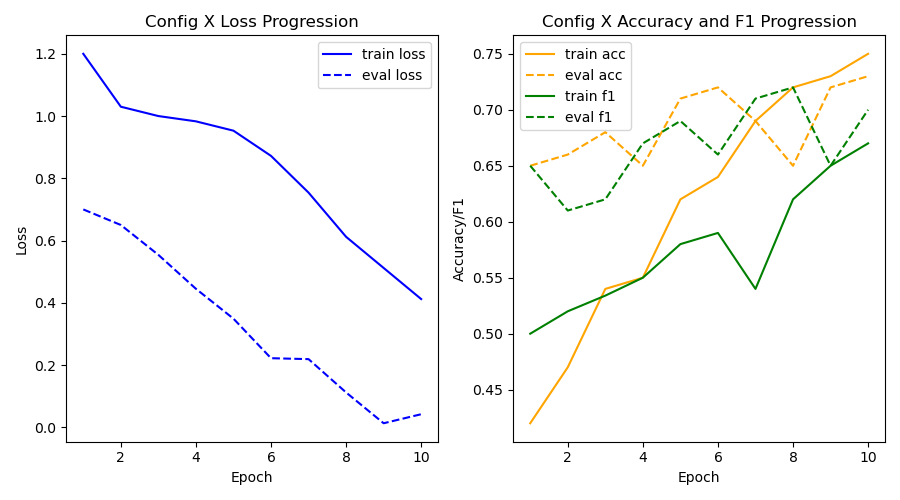


In [208]:
df = pd.read_csv('results.csv')

In [209]:
df.to_clipboard(sep=',', index=False)

In [210]:
# show all rows of the dataframe
pd.set_option('display.max_rows', None)

df.query(f'config == {2}')

,config,epoch,train_loss,train_acc,train_f1,val_loss,val_acc,val_f1
15,2,0,0.682734,0.533973,0.003649,0.640792,0.50912,0.369503
16,2,1,0.635786,0.596747,0.348021,0.848803,0.48656,0.287047
17,2,2,0.606531,0.639573,0.476530,0.610947,0.64448,0.646741
18,2,3,0.579207,0.670347,0.551679,0.581181,0.66176,0.657818
19,2,4,0.552428,0.694667,0.598274,0.600476,0.68112,0.693903
20,2,5,0.532740,0.716213,0.635673,0.615028,0.66944,0.658963
21,2,6,0.509675,0.730667,0.662117,0.610380,0.68496,0.679264
22,2,7,0.496943,0.742507,0.680392,0.765193,0.66224,0.638960


C:\Users\esual\AppData\Local\Temp\ipykernel_53080\1624495070.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


config == 1
ax=0
config == 2
ax=1
config == 3
ax=2


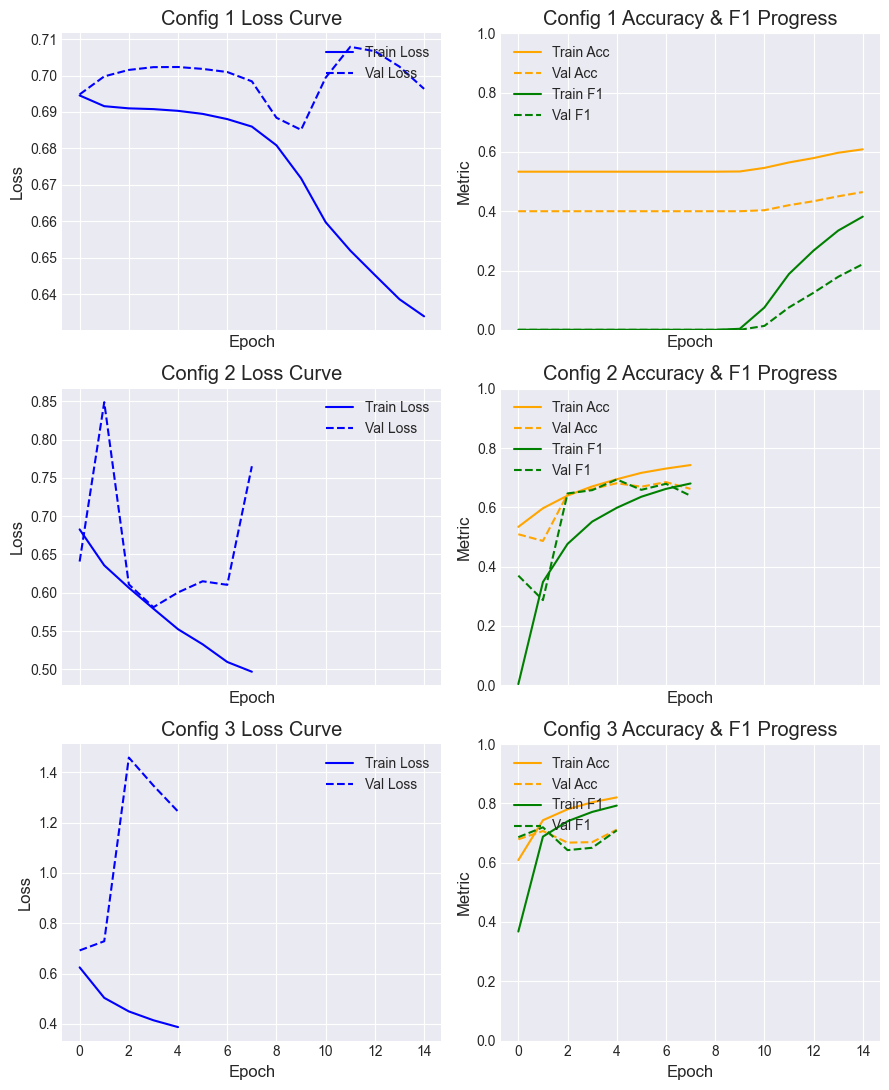

In [211]:
fig, ax = plt.subplots(3, 2, figsize=(9, 11), sharex=True)
plt.style.use('seaborn-darkgrid')

for i in range(1,4):
    print(f'config == {i}')
    print(f'ax={i-1}')
    df_graph = df.query(f'config == {i}')
    # loss
    ax[i-1,0].plot(df_graph['epoch'], df_graph['train_loss'], color='blue')
    ax[i-1,0].plot(df_graph['epoch'], df_graph['val_loss'], color='blue', linestyle='--')
    ax[i-1,0].set_title(f'Config {i} Loss Curve')
    ax[i-1,0].set_xlabel('Epoch')
    ax[i-1,0].set_ylabel('Loss')
    ax[i-1,0].legend(['Train Loss', 'Val Loss'], loc='upper right')
    # set ylim to 1
    # progress
    ax[i-1,1].plot(df_graph['epoch'], df_graph['train_acc'], color='orange')
    ax[i-1,1].plot(df_graph['epoch'], df_graph['val_acc'], color='orange', linestyle='--')
    ax[i-1,1].plot(df_graph['epoch'], df_graph['train_f1'], color='green')
    ax[i-1,1].plot(df_graph['epoch'], df_graph['val_f1'], color='green', linestyle='--')
    ax[i-1,1].set_title(f'Config {i} Accuracy & F1 Progress')
    ax[i-1,1].set_xlabel('Epoch')
    ax[i-1,1].set_ylabel('Metric')
    ax[i-1,1].legend(['Train Acc', 'Val Acc', 'Train F1', 'Val F1'], loc='upper left')
    ax[i-1,1].set_ylim(0, 1)


plt.tight_layout()
plt.show()


___

Student answer here:

## Config 1
- The learning is quite slow due to the less complexity of the model. The model is underfitting.
- In parallel with that, loss function stagnates. 
- Starting from 10th epoch, both F1 and accuracy increases. Yet they're still far lower than the other configs.

## Config 2
- Compared to Config 1, Accuracy increases from ~0.4 to ~0.8.
- Similarly to Accuracy, we can say that F1 improves more quickly. Having higher validation F1 indicates better generalization performance.
- Yet, starting from 7th epoch, Validation loss increases. Which is a sign of overfitting to training data.

## Config 3
- Apparently, the model overfits from the beginning as having higher validation loss.
- Both accuracy and F1 are lower for training data. 
- The curves indicate instable learning process, related to overcomplexity of the model.
___

* As the final step, instantiate a model with the config of the best run
* Load the `state_dict`
* Evaluate it on the test set
    * Don't forget to actviate evaluation mode and deactivate gradient calculation
* Comment on the performance
    * Did it generalize well? Why? Why not?
    * What could be done to improve the performance even further?
        * Consider also the hyperparameters from the third cell and discuss potential tradeoffs.

In [ ]:
# evaluate on test set
paramset = configs['config2']

model = BiLSTM(
    vocab_size=paramset['vocab_size'], 
    embedding_dim=paramset['embedding_dim'],
    rnn_size=paramset['rnn_size'],
    hidden_size=paramset['hidden_size'],
    dropout=paramset['dropout']
    )


model.load_state_dict(torch.load("best_model.pt"))
model.to(device)

test_loss, test_acc, test_f1 = process(model, test_loader, criterion=criterion, optim=None)

print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}, Test F1: {test_f1:.4f}")

Evaluating: 100%|██████████| 782/782 [00:13<00:00, 57.01batches/s]
Test Loss: 0.5256, Test Acc: 0.7637, Test F1: 0.7658


In [ ]:
df.query('config == 2 and epoch == 7') 

,config,epoch,train_loss,train_acc,train_f1,val_loss,val_acc,val_f1
22,2,7,0.496432,0.743573,0.682556,0.523339,0.76464,0.799946


___

Student answer here:

- All train, validatio and test losses are close to each other. This is a good sign in terms of generalization. The model predicts well with the unseen data.
- To improve our model, we can try different configs, searching values between config 2 and config 3. Playing around different embedding dim and hidden size might be a good start.
- To the models which are more complex than config 2, we can introduce new regularization methods (i.e. weight decay, gradient clipping, etc.)
- Regarding to the hyperparameters from the third cell:
    - Larger vocab size could result in better classification, yet it reduces computational performance and add complexity.
    - Smaller batch size is an option for better generalization, however it will decrease the update stability in each step.
    - More epochs won't help in this case, since Config 2 and Config 3 stopped already early.
    - We can choose more epoch with smaller learning rate. It will converge better but slower. Adaptive learning rate would overcome the latter concern.
___